In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read data set from computer
df = pd.read_csv('cost-of-living-2018.csv')
df.head()

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,NaN,"Hamilton, Bermuda",145.43,110.87,128.76,143.47,158.75,112.26
1,NaN,"Zurich, Switzerland",141.25,66.14,105.03,149.86,135.76,142.70
2,NaN,"Geneva, Switzerland",134.83,71.70,104.38,138.98,129.74,130.96
3,NaN,"Basel, Switzerland",130.68,49.68,91.61,127.54,127.22,139.01
4,NaN,"Bern, Switzerland",128.03,43.57,87.30,132.70,119.48,112.71


In [3]:
# Get information from the data set
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
Rank                              0 non-null float64
City                              540 non-null object
Cost of Living Index              540 non-null float64
Rent Index                        540 non-null float64
Cost of Living Plus Rent Index    540 non-null float64
Groceries Index                   540 non-null float64
Restaurant Price Index            540 non-null float64
Local Purchasing Power Index      540 non-null float64
dtypes: float64(7), object(1)
memory usage: 33.8+ KB
None


In [4]:
# Data cleaning: 1)Drop the Rank column which doesn't provide any useful information
df = df.drop('Rank', axis = 1)

# Data cleaning: 2)Rename the columns to make them more accessible
df.rename(columns = {'Cost of Living Index':'Living'}, inplace = True)
df.rename(columns = {'Rent Index':'Rent'}, inplace = True)
df.rename(columns = {'Cost of Living Plus Rent Index':'Living&Rent'}, inplace = True)
df.rename(columns = {'Groceries Index':'Groceries'}, inplace = True)
df.rename(columns = {'Restaurant Price Index':'Restaurant'}, inplace = True)
df.rename(columns = {'Local Purchasing Power Index':'Power'}, inplace = True)

# Because all the columns with numerical variables have the same amount of data and are of the same type, they don't need to be adjusted

df.head()

,City,Living,Rent,Living&Rent,Groceries,Restaurant,Power
0,"Hamilton, Bermuda",145.43,110.87,128.76,143.47,158.75,112.26
1,"Zurich, Switzerland",141.25,66.14,105.03,149.86,135.76,142.70
2,"Geneva, Switzerland",134.83,71.70,104.38,138.98,129.74,130.96
3,"Basel, Switzerland",130.68,49.68,91.61,127.54,127.22,139.01
4,"Bern, Switzerland",128.03,43.57,87.30,132.70,119.48,112.71


In [5]:
# Drop the "City" column and create a one-hot matrix
new_df = df.drop(columns=['City'])
new_df = pd.get_dummies(df['City'])
input_data = df.drop('City', axis = 1)
input_data = input_data.join(new_df)
input_data.head()

,Living,Rent,Living&Rent,Groceries,Restaurant,Power,"Aachen, Germany","Aalborg, Denmark","Aberdeen, United Kingdom","Abu Dhabi, United Arab Emirates",...,"Winnipeg, Canada","Winston-salem, NC, United States","Wroclaw, Poland","Yekaterinburg, Russia","Yerevan, Armenia","Yogyakarta, Indonesia","York, United Kingdom","Zagreb, Croatia","Zaragoza (Saragossa), Spain","Zurich, Switzerland"
0,145.43,110.87,128.76,143.47,158.75,112.26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,141.25,66.14,105.03,149.86,135.76,142.70,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,134.83,71.70,104.38,138.98,129.74,130.96,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,130.68,49.68,91.61,127.54,127.22,139.01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,128.03,43.57,87.30,132.70,119.48,112.71,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Sort variables according to correlations
df.corr()['Living'].sort_values(ascending=False)
# Cost of Living Plus Rent Index was most positively correlated with Cost of Living Index
# Local Purchasing Power Index was most negatively correlated with Cost of Living Index

Living         1.000000
Living&Rent    0.960384
Groceries      0.947438
Restaurant     0.947047
Rent           0.788042
Power          0.635456
Name: Living, dtype: float64

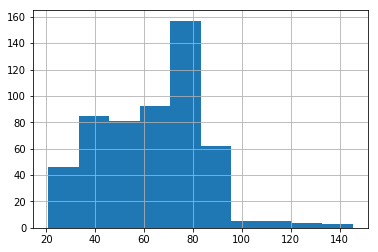

In [7]:
# My predictor variable is a little skewed right
df['Living'].hist()

In [8]:
df.head()

,City,Living,Rent,Living&Rent,Groceries,Restaurant,Power
0,"Hamilton, Bermuda",145.43,110.87,128.76,143.47,158.75,112.26
1,"Zurich, Switzerland",141.25,66.14,105.03,149.86,135.76,142.70
2,"Geneva, Switzerland",134.83,71.70,104.38,138.98,129.74,130.96
3,"Basel, Switzerland",130.68,49.68,91.61,127.54,127.22,139.01
4,"Bern, Switzerland",128.03,43.57,87.30,132.70,119.48,112.71


In [4]:
# Change all values to log in order to eliminate the skew
df['log_Living'] = np.log(df['Living'])
df['log_Rent'] = np.log(df['Rent'])
df['log_Living&Rent'] = np.log(df['Living&Rent'])
df['log_Groceries'] = np.log(df['Groceries'])
df['log_Restaurant'] = np.log(df['Restaurant'])
df['log_Power'] = np.log(df['Power'])
new_df = df.drop(columns=['Living'])
new_df.head()

,City,Rent,Living&Rent,Groceries,Restaurant,Power,log_Living,log_Rent,log_Living&Rent,log_Groceries,log_Restaurant,log_Power
0,"Hamilton, Bermuda",110.87,128.76,143.47,158.75,112.26,4.979695,4.708358,4.857950,4.966126,5.067331,4.720818
1,"Zurich, Switzerland",66.14,105.03,149.86,135.76,142.70,4.950531,4.191774,4.654246,5.009702,4.910889,4.960745
2,"Geneva, Switzerland",71.70,104.38,138.98,129.74,130.96,4.904015,4.272491,4.648038,4.934330,4.865532,4.874892
3,"Basel, Switzerland",49.68,91.61,127.54,127.22,139.01,4.872752,3.905602,4.517540,4.848430,4.845918,4.934546
4,"Bern, Switzerland",43.57,87.30,132.70,119.48,112.71,4.852265,3.774369,4.469350,4.888091,4.783149,4.724818


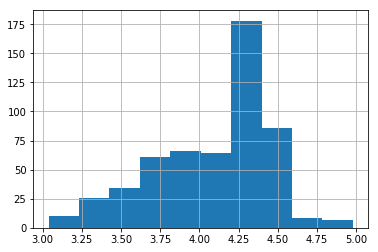

In [10]:
df['log_Living'].hist()

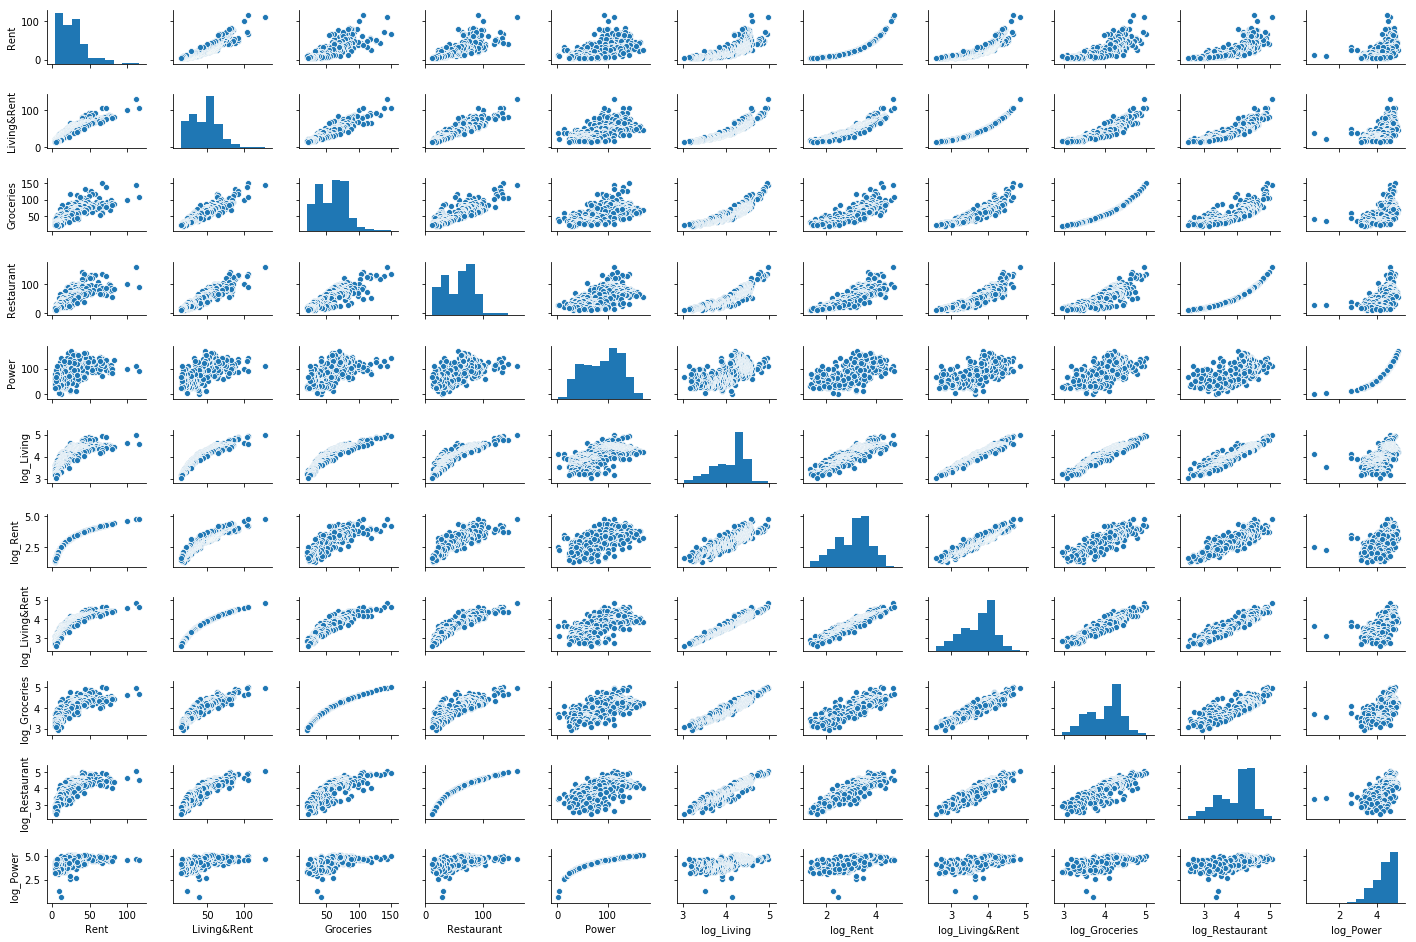

In [11]:
# Scatterplots of variables versus each other
sns.pairplot(new_df, height = 1.2, aspect=1.5)

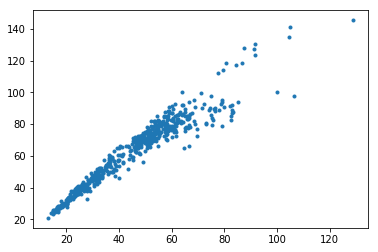

In [5]:
# Cost of Living Plus Rent Index is chosen as explanatory variable
X = df['Living&Rent']
y = df['Living']

# Plot Cost of Living Plus Rent Index vs Living Index
plt.plot(X,y, '.');

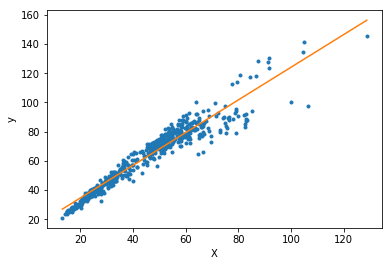

In [6]:
# Fit a linear regression to the data
model = LinearRegression()
X = df['Living&Rent'][:,np.newaxis]
model.fit(X, y)
y_pred = model.predict(X)
plt.plot(X,y,'.', X, model.predict(X));
plt.xlabel('X');
plt.ylabel('y');

[433.6663825956721, 4.1449717667301125e-05, 3.96558012400139e-05, 3.536846627953858e-05, 2.899915520710498e-05, 0.0001483438345634984, 1.881113310584541e-09] [503.43183086046497, 4.7970899291998775e-05, 4.903465141663083e-05, 6.535877487543828e-05, 0.0033332461177849712, 1.6946727856047499, 71329.93591145912]


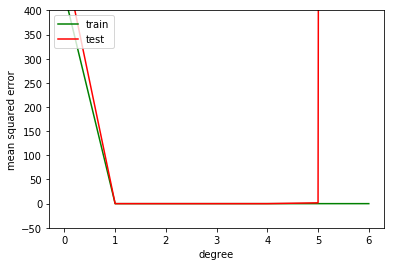

In [7]:
df2 = df.drop(columns = ['City', 'Living'])

# Try degrees 0-7 to figure out the best degree of polynomial for the data set
X_train, X_test, y_train, y_test = train_test_split(df2, y, shuffle=True, test_size=0.3)

#X_train = X_train.values.reshape(-1, 1)
#X_test = X_test.values.reshape(-1, 1)
#y_train= y_train.values.reshape(-1, 1)
#y_test = y_test.values.reshape(-1, 1)

mindegree = 0
maxdegree = 7
train_error = []
test_error = []
for deg in range(mindegree,maxdegree):
    model = make_pipeline(PolynomialFeatures(deg),LinearRegression())
    model.fit(X_train,y_train)
    train_error.append(mean_squared_error(y_train,model.predict(X_train)))
    test_error.append(mean_squared_error(y_test,model.predict(X_test)))
print(train_error,test_error)
plt.plot(np.arange(mindegree,maxdegree), train_error, color='green', label='train')
plt.plot(np.arange(mindegree,maxdegree), test_error, color='red', label='test')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.ylim((-50,400))
plt.legend(loc='upper left')

In [8]:
# Degree 1 is chosen as the polynomial model
one_hot = pd.get_dummies(df['City'])
df1 = df.drop(columns = ['City'])
poly = PolynomialFeatures(1)
poly.fit(df1)
df1_poly = poly.transform(df1)
df1_poly

array([[  1.  , 145.43, 110.87, ..., 143.47, 158.75, 112.26],
       [  1.  , 141.25,  66.14, ..., 149.86, 135.76, 142.7 ],
       [  1.  , 134.83,  71.7 , ..., 138.98, 129.74, 130.96],
       ...,
       [  1.  ,  23.78,   4.34, ...,  23.19,  17.66,  23.75],
       [  1.  ,  23.44,   6.25, ...,  24.02,  14.14, 111.99],
       [  1.  ,  20.86,   5.1 , ...,  21.98,  12.06,  66.25]])

In [9]:
# Scale data
scaler = StandardScaler()
scaler.fit(df1_poly)
X_scaled = scaler.transform(df1_poly)
X_scaled

array([[ 0.        ,  3.83657706,  4.87725534, ...,  3.78688714,
         3.80719619,  0.60474656],
       [ 0.        ,  3.64048096,  2.27071009, ...,  4.07552592,
         2.92936322,  1.43768875],
       [ 0.        ,  3.33929986,  2.59470722, ...,  3.58407209,
         2.69950005,  1.11644232],
       ...,
       [ 0.        , -1.8703826 , -1.33055296, ..., -1.64620721,
        -1.58007882, -1.81718884],
       [ 0.        , -1.886333  , -1.21925178, ..., -1.60871579,
        -1.71448387,  0.59735844],
       [ 0.        , -2.00736839, -1.28626558, ..., -1.70086338,
        -1.79390503, -0.65424393]])

In [10]:
# Create one-hot matrix
X = one_hot.join(pd.DataFrame(X_scaled))
X.head()

,"Aachen, Germany","Aalborg, Denmark","Aberdeen, United Kingdom","Abu Dhabi, United Arab Emirates","Accra, Ghana","Ad Dammam, Saudi Arabia","Addis Ababa, Ethiopia","Adelaide, Australia","Ahmedabad, India","Akron, OH, United States",...,"Zagreb, Croatia","Zaragoza (Saragossa), Spain","Zurich, Switzerland",0,1,2,3,4,5,6
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,3.836577,4.877255,4.523621,3.786887,3.807196,0.604747
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0.0,3.640481,2.270710,3.225646,4.075526,2.929363,1.437689
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,3.339300,2.594707,3.190093,3.584072,2.699500,1.116442
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,3.144611,1.311539,2.491604,3.067323,2.603278,1.336718
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,3.020292,0.955492,2.255857,3.300402,2.307740,0.617060


In [43]:
# Split training and testing set and apply linear regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 99)
model = LinearRegression()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.9998734558220714


In [63]:
# Apply RidgeCV find alpha, intercept and coefficient
model = RidgeCV(alphas = [0.0001, 0.1, 1], store_cv_values=True).fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.alpha_)
print(model.intercept_)
print(model.coef_)
X.columns
# Equation: Cost of Living Index = 63.64691073116853 + 5.21280148e-01 * Aachen, Germany + 2.02062927e-01 * Aalborg, Denmark +

0.9999999999987215
0.0001
63.64691073116853
[ 5.21280148e-01  2.02062927e-01 -5.83724614e-02  1.10299423e-01
  3.06547425e-01  4.57688420e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.10987743e-01  3.87656941e-01  1.97138913e-02
 -2.56212775e-01  0.00000000e+00  0.00000000e+00 -1.92948003e-01
  3.34896767e-02  3.30944711e-01  2.34533898e-02  2.10672603e-02
  8.97556966e-02  2.21255245e-02 -2.25156938e-01  0.00000000e+00
  0.00000000e+00  4.97171861e-03  9.57123944e-02 -2.88258139e-01
 -3.42859035e-01 -4.89199356e-02 -1.34608628e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.50661419e-02 -1.52682244e-01  0.00000000e+00 -9.56780870e-02
 -1.92771697e-01  0.00000000e+00 -1.54761278e-01  2.10316888e-01
  0.00000000e+00  0.00000000e+00 -9.33187326e-02  0.00000000e+00
  1.95063125e-01 -2.38102294e-02  2.33585572e-01  0.00000000e+00
  1.31615971e-01  0.00000000e+00 -2.37296316e-01  2.98823730e-01
 -1.51760066e-01  1.31807725e-01 -2.16326981e-

Index([                'Aachen, Germany',                'Aalborg, Denmark',
              'Aberdeen, United Kingdom', 'Abu Dhabi, United Arab Emirates',
                          'Accra, Ghana',         'Ad Dammam, Saudi Arabia',
                 'Addis Ababa, Ethiopia',             'Adelaide, Australia',
                      'Ahmedabad, India',        'Akron, OH, United States',
       ...
                       'Zagreb, Croatia',     'Zaragoza (Saragossa), Spain',
                   'Zurich, Switzerland',                                 0,
                                       1,                                 2,
                                       3,                                 4,
                                       5,                                 6],
      dtype='object', length=547)

In [59]:
# Find MSE value for training set
model = RidgeCV(alphas = [0.0001, 0.1, 1], store_cv_values=True).fit(X_train, y_train)
mean_squared_error(y_true=y, y_pred=model.predict(X))
model.cv_values_.mean()

0.10568223195212435

In [60]:
# Find MSE value for testing set
model = RidgeCV(alphas = [0.0001, 0.1, 1], store_cv_values=True).fit(X_test, y_test)
mean_squared_error(y_true=y, y_pred=model.predict(X))
model.cv_values_.mean()

0.4279033917929

In [62]:
# Get the R^2 values of the model
print('R^2 of Train:', {model.score(X_train,y_train)})
print('Adjusted R^2:', {1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X_train.shape[1]-1)})
print('R^2 of Test:', {model.score(X_test,y_test)})
print('Adjusted R^2:', {1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X_test.shape[1]-1)})

R^2 of Train: {0.9999999999987215}
Adjusted R^2: {1.0027265455480472}
R^2 of Test: {0.9998734335255349}
Adjusted R^2: {1.0027265455480472}


In [ ]:
# Bias can be defined as the accuracy that cost of living index is being predicted, which appears to be high because of the score of the model
# Variance can be defined as the difference between the result of the training and testing sets, which appears to be a low variance because the results of training and testing sets are similar